In [1]:
import sys
import json
import nltk
import random
import itertools

import pandas as pd
import numpy as np
from functools import cache, partial
from IPython.display import display
from nltk.treeprettyprinter import TreePrettyPrinter
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, '../..')

%matplotlib inline
from utils.progress import track, get_progress_bar
from data_scripts.subsample.utils import get_samples
from data_scripts.subsample.substructs import get_subtrees, get_templates, get_sent_ngrams
from data_scripts.subsample.algos import iterative_subsample

from experiments.analysis.utils.lf_utils import jaccard, tokenize_lf, TOKENS_TO_IGNORE
from generation.scfg.grammar import NonTerminal, Production, SyncGrammar
from generation.scfg.covr.grammars import grammar1, grammar1_ambiguous, grammar_ben
from generation.scfg.generate import Generation, Generator, DiverseGenerator, rule_seq_to_parse_tree
from generation.scfg.subtree_extractor import SubtreeExtractor
from generation.scfg.utils import is_subtree, remove_puncts_from_parse_tree, is_subtree, tuple_to_tree, get_tree_size, get_tuple_size

In [2]:
def plot_pool_freq_hist(comp2ex_d, ax=None, plot_pool=False, normalize=False):
    if not plot_pool:
        data = [
            pd.DataFrame([len(comp2ex_d['full'][s]) for s in comp2ex_d['diverse']], columns=['Frequency in Pool']).assign(Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])}/{len(comp2ex_d["full"])})'),
            pd.DataFrame([len(comp2ex_d['full'][s]) for s in comp2ex_d['random']], columns=['Frequency in Pool']).assign(Subsample=f'Random ({len(comp2ex_d["random"])}/{len(comp2ex_d["full"])})')
        ]
    else:
        data = [
            pd.DataFrame([len(comp2ex_d['full'][s]) for s in comp2ex_d['diverse']], columns=['Frequency in Pool']).assign(Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])})'),
            pd.DataFrame([len(comp2ex_d['full'][s]) for s in comp2ex_d['random']], columns=['Frequency in Pool']).assign(Subsample=f'Random ({len(comp2ex_d["random"])})'),
            pd.DataFrame([len(comp2ex_d['full'][s]) for s in comp2ex_d['full']], columns=['Frequency in Pool']).assign(Subsample=f'Pool ({len(comp2ex_d["full"])})'),
        ]
    data = pd.concat(data)
    if not normalize: sns.histplot(data=data, x='Frequency in Pool', hue='Subsample', kde=True, ax=ax, element="step", log_scale=True)
    else: sns.histplot(data=data, x='Frequency in Pool', hue='Subsample', kde=True, ax=ax, element="step", stat='probability', common_norm=False, log_scale=True)
    
def plot_pool_freq_scatter(comp2ex_d, ax=None, plot_pool=False):
    import scipy.stats
    ranks = scipy.stats.rankdata([-len(comp2ex_d['full'][s]) for s in comp2ex_d['full']], method='ordinal')
    comp2rank = {s: ranks[i] for i, s in enumerate(comp2ex_d['full'])}
    data = [
        pd.DataFrame.from_records([{
            'Rank in Pool': comp2rank[s],
            'Frequency in Sample': len(comp2ex_d['diverse'][s])
            } for s in comp2ex_d['diverse']]).assign(
                Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])})'),
        pd.DataFrame.from_records([{
            'Rank in Pool': comp2rank[s],
            'Frequency in Sample': len(comp2ex_d['random'][s])
            } for s in comp2ex_d['random']]).assign(
                Subsample=f'Random ({len(comp2ex_d["random"])})'),
    ]
    if plot_pool:
        data.append(pd.DataFrame.from_records([{
            'Rank in Pool': comp2rank[s],
            'Frequency in Sample': len(comp2ex_d['full'][s])
            } for s in comp2ex_d['full']]).assign(
                Subsample=f'Pool ({len(comp2ex_d["full"])})'),)
    data = pd.concat(data)
    sns.scatterplot(data=data, x='Rank in Pool', y='Frequency in Sample', hue='Subsample', style='Subsample', ax=ax, 
                    # alpha=1, 
                    s=20
                    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    
def plot_pool_rank_hist(comp2ex_d, ax=None, plot_pool=False, normalize=False, rank_method='average'):
    import scipy.stats
    ranks = scipy.stats.rankdata([-len(comp2ex_d['full'][s]) for s in comp2ex_d['full']], method=rank_method)
    comp2rank = {s: ranks[i] for i, s in enumerate(comp2ex_d['full'])}
    if not plot_pool:
        data = [
            pd.DataFrame([comp2rank[s] for s in comp2ex_d['diverse']], columns=['Rank in Pool']).assign(Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])}/{len(comp2ex_d["full"])})'),
            pd.DataFrame([comp2rank[s] for s in comp2ex_d['random']], columns=['Rank in Pool']).assign(Subsample=f'Random ({len(comp2ex_d["random"])}/{len(comp2ex_d["full"])})'),
        ]
    else:        
        data = [
            pd.DataFrame([comp2rank[s] for s in comp2ex_d['diverse']], columns=['Rank in Pool']).assign(Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])})'),
            pd.DataFrame([comp2rank[s] for s in comp2ex_d['random']], columns=['Rank in Pool']).assign(Subsample=f'Random ({len(comp2ex_d["random"])})'),
            pd.DataFrame([comp2rank[s] for s in comp2ex_d['full']], columns=['Rank in Pool']).assign(Subsample=f'Pool ({len(comp2ex_d["full"])})')
        ]
    data = pd.concat(data)
    if rank_method != 'ordinal':
        if not normalize: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, kde=True, element="step", bins='doane')
        else: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, kde=True, element="step", 
                        stat='probability', common_norm=False)
    else:
        if not normalize: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, kde=True, element="step", bins=100)
        else: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, kde=True, element="step", 
                        stat='probability', common_norm=False, bins=100)

def plot_pool_rank_hist2(comp2ex_d, ax=None, plot_pool=False, normalize=False, rank_method='average'):
    import scipy.stats
    ranks = scipy.stats.rankdata([-len(comp2ex_d['full'][s]) for s in comp2ex_d['full']], method=rank_method)
    comp2rank = {s: ranks[i] for i, s in enumerate(comp2ex_d['full'])}
    data = [
        pd.DataFrame([comp2rank[s] for s in comp2ex_d['diverse'] for _ in comp2ex_d['diverse'][s]], 
                     columns=['Rank in Pool']).assign(Subsample=f'Subtree Diverse ({len(comp2ex_d["diverse"])})'),
        pd.DataFrame([comp2rank[s] for s in comp2ex_d['random'] for _ in comp2ex_d['random'][s]], 
                     columns=['Rank in Pool']).assign(Subsample=f'Random ({len(comp2ex_d["random"])})'),
    ]
    if normalize and rank_method == 'ordinal':
        for frac in [0.1, 0.2, 0.3]:
            n_ex = {k: 0 for k in comp2ex_d}
            total_n_ex = {k: 0 for k in comp2ex_d}
            for s, rank in comp2rank.items():
                for k in comp2ex_d:
                    total_n_ex[k] += len(comp2ex_d[k][s]) if s in comp2ex_d[k] else 0
                if rank < len(ranks) * frac:
                    for k in comp2ex_d:
                        n_ex[k] += len(comp2ex_d[k][s]) if s in comp2ex_d[k] else 0
            n_ex = {k: n_ex[k] / total_n_ex[k] for k in comp2ex_d}
            print(frac, f"{n_ex['full'] - n_ex['diverse']:3f}")
    if plot_pool:
        data.append(pd.DataFrame([comp2rank[s] for s in comp2ex_d['full'] for _ in comp2ex_d['full'][s]], 
                                 columns=['Rank in Pool']).assign(Subsample=f'Pool ({len(comp2ex_d["full"])})'))
    data = pd.concat(data)
    if rank_method != 'ordinal':
        if not normalize: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, cumulative=True, element="step")
        else: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, cumulative=True, element="step", 
                        stat='probability', common_norm=False)
    else:
        if not normalize: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, cumulative=True, element="step", bins=100)
        else: sns.histplot(data=data, x='Rank in Pool', hue='Subsample', ax=ax, cumulative=True, element="step", 
                        stat='probability', common_norm=False, bins=100)

def plot_pool_freq_hist_all(all_comp2ex_d, comp_name='subtree', plot_fn=plot_pool_freq_hist, plot_name=None):
    fig, axs = plt.subplots(1, len(ds_names), figsize=(len(ds_names)*4, 4))
    for i, ds_name in enumerate(ds_names):
        plot_fn(all_comp2ex_d[ds_name], axs[i])
        axs[i].set_title(f'{ds_name_map[ds_name]} ({sample_size_d[ds_name]}/{all_dfs[ds_name]["full"].shape[0]})')

        # Save just the portion _inside_ the second axis's boundaries padded by 10% in the x-direction and 20% in the y-direction
        # extent = axs[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        extent = full_extent(axs[i]).transformed(fig.dpi_scale_trans.inverted())
        if plot_name is not None: fig.savefig(f'figures/{ds_name}-{comp_name}-{plot_name}.svg', bbox_inches=extent, dpi=1200)
    plt.tight_layout()
    if plot_name is not None: fig.savefig(f'figures/all-{comp_name}-{plot_name}.svg', dpi=12000)

plot_name_d = {
    plot_pool_freq_hist: 'pool_freq-hist',
    plot_pool_rank_hist: 'pool_rank-hist',
    plot_pool_freq_scatter: 'pool_freq-scatter',
}
def get_plot_name(plot_fn, plot_pool, normalize=False):
    if plot_fn in plot_name_d:
        plot_name = plot_name_d[plot_fn]
        if plot_pool: plot_name += '-pool'
        if 'hist' in plot_name and normalize: plot_name += '-norm'
        return plot_name
    else:
        return None

In [3]:
from matplotlib.transforms import Bbox
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    # return bbox.expanded(1.0 + pad, 1.0 + pad)
    return bbox

### Data

In [4]:
ds_name_map = {'covr': 'COVR', 'atis': 'ATIS', 'thingtalk': 'Schema2QA', 'overnight': 'Overnight', 'smcalflow': 'SM-CalFlow', 'smcalflow-uncommon': 'SM-CalFlow'}

sample_size_d = {
    'atis': 600,
    'covr': 300,
    'overnight': 300,
    'thingtalk': 300,
    'smcalflow': 6000,
    'smcalflow-uncommon': 6000
}

In [5]:
ds_names = [
    'atis', 
    'overnight', 
    'covr', 
    'thingtalk',
    # 'smcalflow', 
    'smcalflow-uncommon'
]
all_dfs, all_subtree2ex_d = {}, {}
instance_counts = []
subtree_counts = []
for i, ds_name in enumerate(ds_names):
    print(ds_name)
    dfs, subtree2ex_d = get_samples(ds_name, sample_size_d[ds_name])
    for name, df in dfs.items(): 
        print(name, dfs[name].shape[0])
        instance_counts.append(dict(ds=ds_name, dataset=ds_name_map[ds_name], sample=name, 
                                   metric_name='instance_cnt', metric_val=df.shape[0]))
    for name, subtree2ex in subtree2ex_d.items():
        subtree_counts.append(dict(ds=ds_name, dataset=ds_name_map[ds_name], sample=name, 
                                   metric_name='subtree_cnt', metric_val=len(subtree2ex)))
    all_dfs[ds_name] = dfs
    all_subtree2ex_d[ds_name] = subtree2ex_d
instance_counts_df = pd.DataFrame.from_records(instance_counts)
subtree_counts_df = pd.DataFrame.from_records(subtree_counts)

smcalflow-uncommon

Output()

Output()

208527 subtrees with max size 4 and context type  and anon=False


21082 templates


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_3027589/4163206538.py:14 in <module>                                              │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3027589/4163206538.py'                      │
│                                                                                                  │
│ /home/shivag5/Documents/research/comp-gen/structural-diversity/notebooks/../data_scripts/subsamp │
│ le/utils.py:28 in get_samples                                                                    │
│                                                                                                  │
│   25 │   template2ex, ex2template, _ = get_templates(trn_pool)                                   │
│   26 │   ex2template = {ex: list(d.keys())[0] for ex, d in ex2template.items()}                  │
│   27 │                                                                                           │
│ ❱ 28 │   diverse_qids = iterative_subsample(                                                     │
│   29 │   │   '5_cyc_fix', subtree2ex, ex2subtree, None, template2ex, ex2template,                │
│   30 │   │   n_trn=sample_size, seed=0, ex_sel='new_template', show_progress=True)               │
│   31                                                                                             │
│                                                                                                  │
│ /home/shivag5/Documents/research/comp-gen/structural-diversity/notebooks/../data_scripts/subsamp │
│ le/algos/iterative.py:12 in iterative_subsample                                                  │
│                                                                                                  │
│     9 │   n_trn=1000, ex_sel='random', seed=0, show_progress=True):                              │
│    10 │   random.seed(seed)                                                                      │
│    11 │   comp2ex = deepcopy(comp2ex)                                                            │
│ ❱  12 │   ex2comp = deepcopy(ex2comp)                                                            │
│    13 │   for comp, ex_cntr in comp2ex.items():                                                  │
│    14 │   │   for ex, w in ex_cntr.items():                                                      │
│    15 │   │   │   assert ex in ex2comp and ex2comp[ex][comp] == w                                │
│                                                                                                  │
│ /home/shivag5/miniconda3/envs/pytorch/lib/python3.9/copy.py:146 in deepcopy                      │
│                                                                                                  │
│   143 │                                                                                          │
│   144 │   copier = _deepcopy_dispatch.get(cls)                                                   │
│   145 │   if copier is not None:                                                                 │
│ ❱ 146 │   │   y = copier(x, memo)                                                                │
│   147 │   else:                                                                                  │
│   148 │   │   if issubclass(cls, type):                                                          │
│   149 │   │   │   y = _deepcopy_atomic(x, memo)                                                  │
│                                                                                                  │
│ /home/shivag5/miniconda3/envs/pytorch/lib/python3.9/copy.py:230 in _deepcopy_dict                │
│                                                                                                  │
│   227 │   y = {}                                           

In [7]:
ds_name = 'overnight'
s0 = set([ex for s in all_subtree2ex_d[ds_name]['full'] for ex in all_subtree2ex_d[ds_name]['full'][s] if len(all_subtree2ex_d[ds_name]['full'][s]) < 5])
print(len(all_subtree2ex_d[ds_name]['full']), len([s for s in all_subtree2ex_d[ds_name]['full'] if len(all_subtree2ex_d[ds_name]['full'][s]) < 5]))
print(len(s0))
print(len(all_dfs[ds_name]['diverse'].query('qid in @s0')))
print(len(all_dfs[ds_name]['random'].query('qid in @s0')))

3015 361

341

56

23

### Final

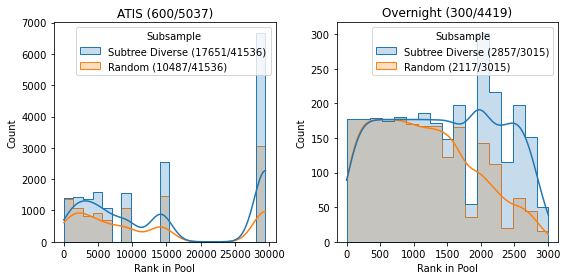

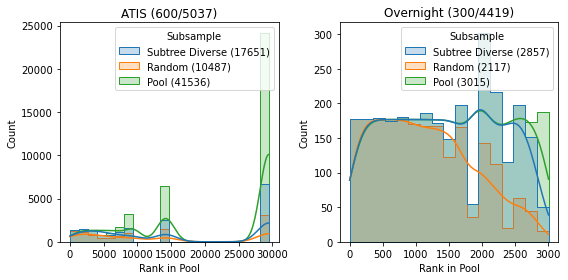

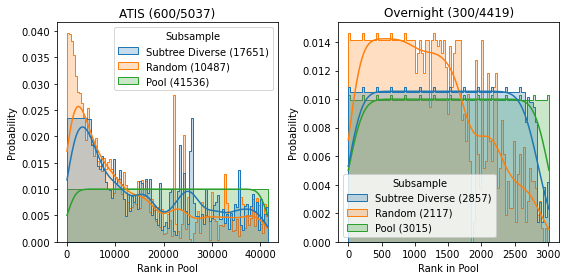

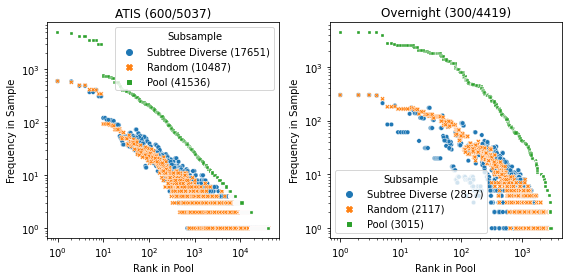

In [8]:
# plot_fn = partial(plot_pool_freq_hist, normalize=False, plot_pool=False)
# plot_name = get_plot_name(plot_pool_freq_hist, plot_pool=False, normalize=False)
# plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

# plot_fn = partial(plot_pool_rank_hist, normalize=True, plot_pool=False, rank_method='ordinal')
# plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=False, normalize=True)
# plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=True, plot_pool=True, rank_method='ordinal')
plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=True, normalize=True)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

# sample frequency of subtree v/s its pool rank (ordinal) => same subtree appears more frequently
plot_fn = partial(plot_pool_freq_scatter, plot_pool=True)
plot_name = get_plot_name(plot_pool_freq_scatter, plot_pool=True)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

### Subtrees

In [9]:
display(subtree_counts_df.pivot(index='ds', columns='sample', values='metric_val'))

sample,diverse,full,random
ds,,,
atis,17651,41536,10487
overnight,2857,3015,2117


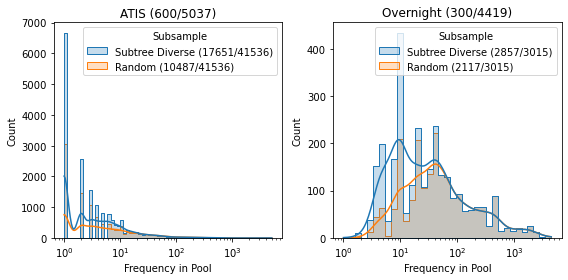

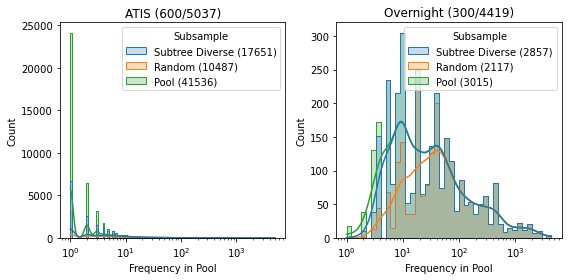

In [10]:
# number/probability of subtrees of a given pool frequency => more subtrees by sampling long-tail of subtrees, approaching pool distribution
for plot_pool in [False, True]:
    plot_fn = partial(plot_pool_freq_hist, normalize=False, plot_pool=plot_pool)
    plot_name = get_plot_name(plot_pool_freq_hist, plot_pool=plot_pool, normalize=False)
    plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

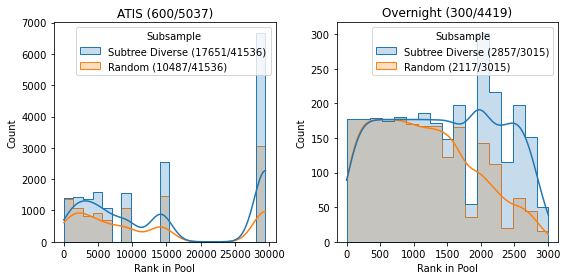

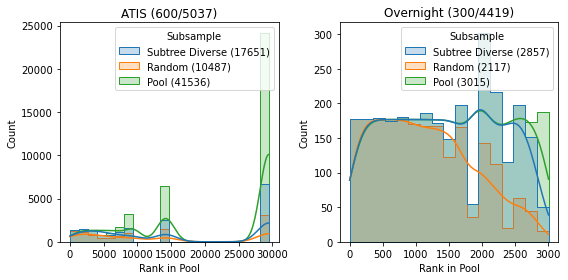

In [11]:
# number/probability of subtrees of a given pool rank => more subtrees by sampling long-tail of subtrees, approaching pool distribution
for plot_pool in [False, True]:
    plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=plot_pool)
    plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=plot_pool, normalize=False)
    plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn)

0.1 0.093554

0.2 0.077568

0.3 0.073604

0.1 0.215060

0.2 0.166651

0.3 0.128939

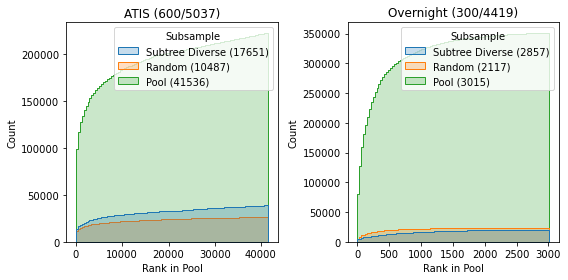

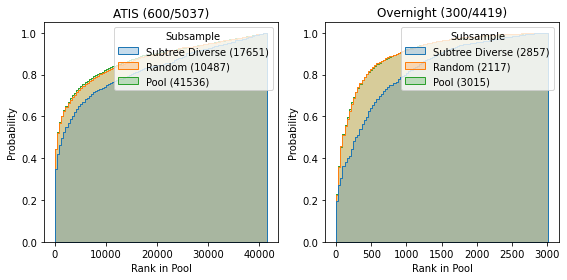

In [12]:
for normalize in [False, True]:
    plot_fn = partial(plot_pool_rank_hist2, normalize=normalize, plot_pool=True, rank_method='ordinal')
    plot_name = get_plot_name(plot_pool_rank_hist2, plot_pool=True, normalize=normalize)
    plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtreee', plot_fn=plot_fn)

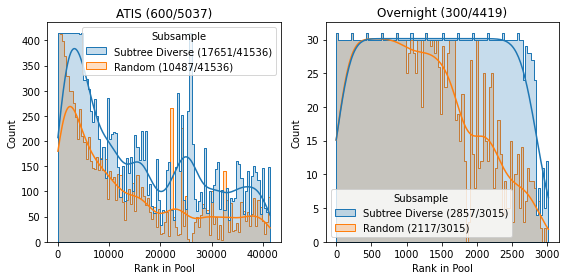

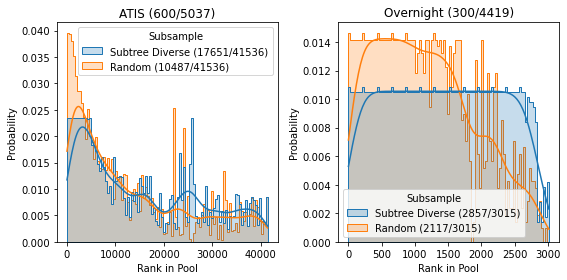

In [13]:
# number/probability of subtrees of a given pool rank (ordinal) => more subtrees by sampling long-tail of subtrees, higher entropy
for normalize in [False, True]:
    plot_fn = partial(plot_pool_rank_hist, normalize=normalize, plot_pool=False, rank_method='ordinal')
    plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=False, normalize=normalize)
    plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

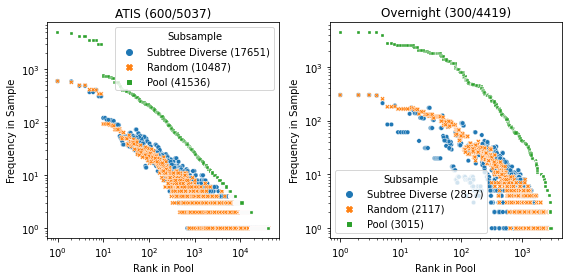

In [14]:
# sample frequency of subtree v/s its pool rank (ordinal) => same subtree appears more frequently
plot_fn = partial(plot_pool_freq_scatter, plot_pool=True)
plot_name = get_plot_name(plot_pool_freq_scatter, plot_pool=True)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

### Templates

In [15]:
all_template2ex_d = {ds_name: {name: get_templates(df)[0] 
                             for name, df in dfs.items()}
                   for ds_name, dfs in all_dfs.items()}
template_counts_df = pd.DataFrame.from_records([
    dict(ds=ds_name, sample=name, metric_name='template_cnt', metric_val=len(template2ex))
    for ds_name, template2ex_d in all_template2ex_d.items()
    for name, template2ex in template2ex_d.items()
])
display(template_counts_df.pivot(index='ds', columns='sample', values='metric_val'))

1149 templates
277 templates
496 templates
87 templates
62 templates
84 templates


sample,diverse,full,random
ds,,,
atis,496,1149,277
overnight,84,87,62


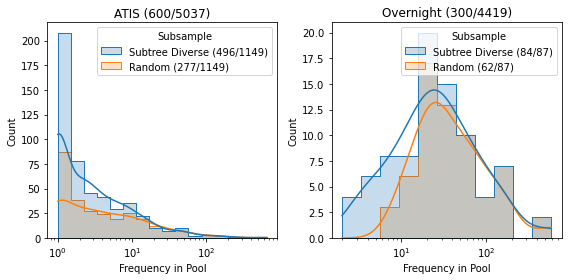

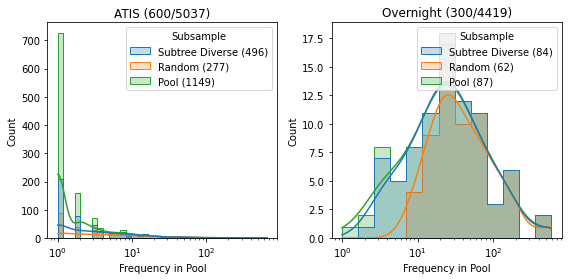

In [16]:
for plot_pool in [False, True]:
    plot_fn = partial(plot_pool_freq_hist, normalize=False, plot_pool=plot_pool)
    plot_name = get_plot_name(plot_pool_freq_hist, plot_pool=plot_pool, normalize=False)
    plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

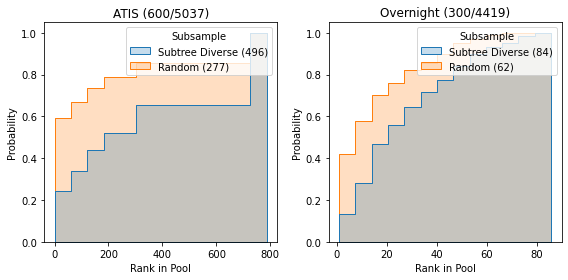

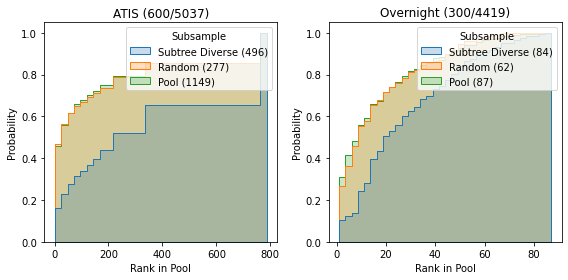

In [17]:
# number/probability of templates of a given pool rank
for plot_pool in [False, True]:
    plot_fn = partial(plot_pool_rank_hist2, normalize=True, plot_pool=plot_pool)
    plot_name = get_plot_name(plot_pool_rank_hist2, plot_pool=plot_pool, normalize=False)
    plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

0.1 0.341395

0.2 0.292484

0.3 0.233031

0.1 0.343594

0.2 0.261853

0.3 0.210475

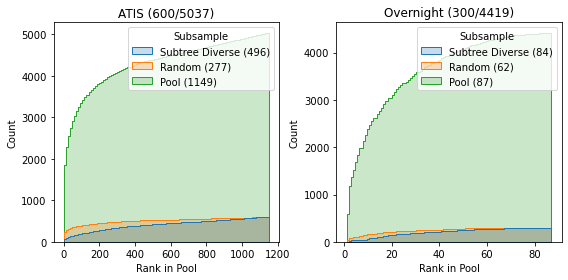

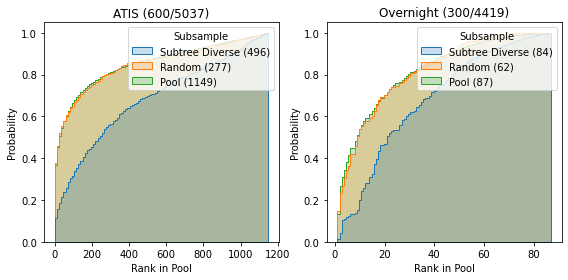

In [18]:
# number/probability of templates of a given pool rank (ordinal)
for normalize in [False, True]:
    plot_fn = partial(plot_pool_rank_hist2, normalize=normalize, plot_pool=True, rank_method='ordinal')
    plot_name = get_plot_name(plot_pool_rank_hist2, plot_pool=True, normalize=normalize)
    plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

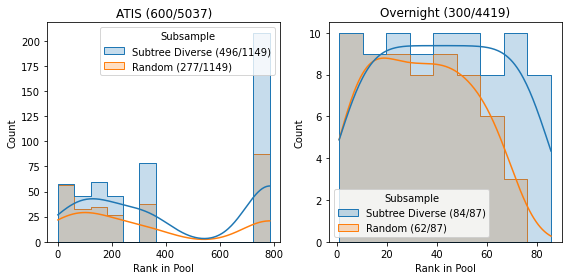

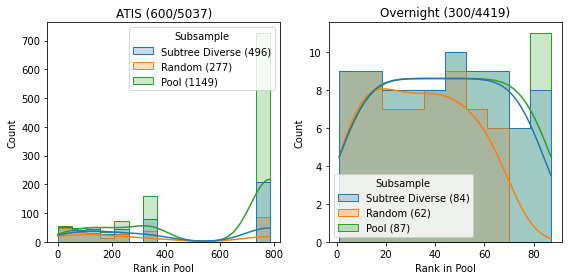

In [19]:
# number/probability of templates of a given pool rank
for plot_pool in [False, True]:
    plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=plot_pool)
    plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=plot_pool, normalize=False)
    plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

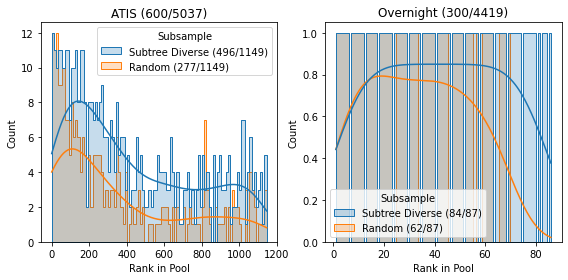

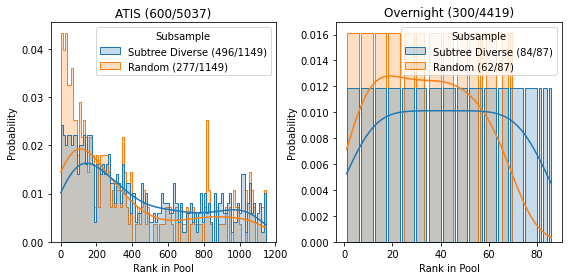

In [20]:
# number/probability of templates of a given pool rank (ordinal)
for normalize in [False, True]:
    plot_fn = partial(plot_pool_rank_hist, normalize=normalize, plot_pool=False, rank_method='ordinal')
    plot_name = get_plot_name(plot_pool_rank_hist, plot_pool=False, normalize=normalize)
    plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

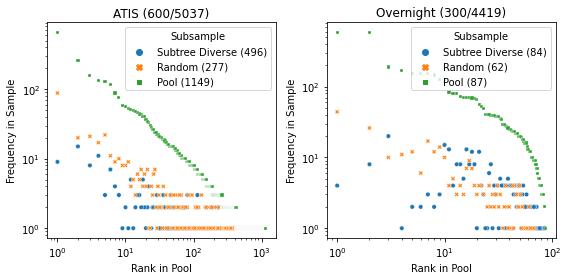

In [21]:
# sample frequency of template v/s its pool rank (ordinal)
plot_fn = partial(plot_pool_freq_scatter, plot_pool=True)
plot_name = get_plot_name(plot_pool_freq_scatter, plot_pool=True, normalize=False)
plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn)

### Unigrams

In [22]:
all_unigram2ex_d = {ds_name: {name: get_sent_ngrams(df, max_n=1, min_n=1)[0] 
                             for name, df in dfs.items()}
                   for ds_name, dfs in all_dfs.items()}
unigram_counts_df = pd.DataFrame.from_records([
    dict(ds=ds_name, sample=name, metric_name='unigram_cnt', metric_val=len(unigram2ex))
    for ds_name, unigram2ex_d in all_unigram2ex_d.items()
    for name, unigram2ex in unigram2ex_d.items()
])
display(unigram_counts_df.pivot(index='ds', columns='sample', values='metric_val'))

sample,diverse,full,random
ds,,,
atis,499,949,486
overnight,71,72,66


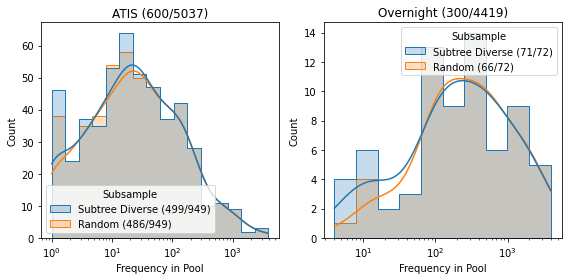

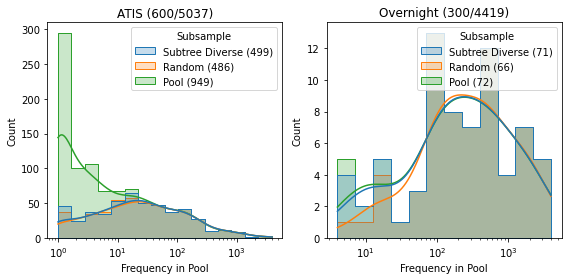

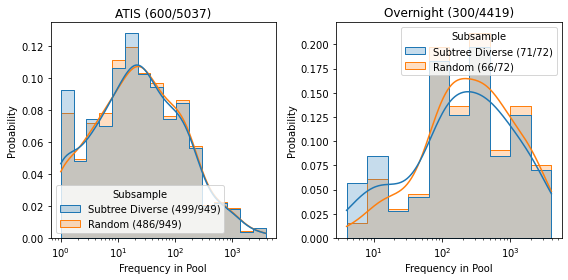

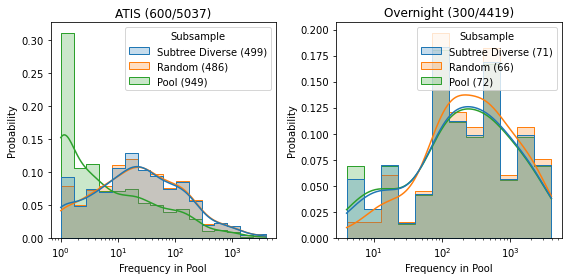

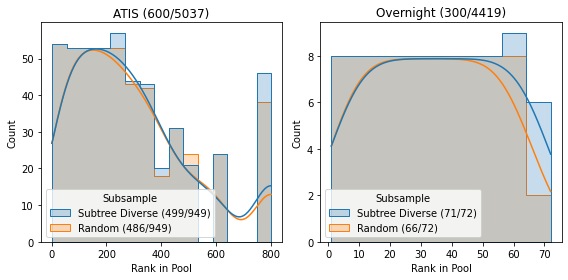

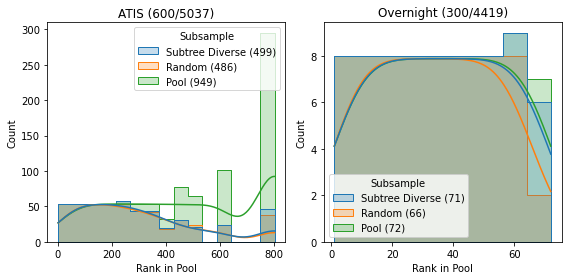

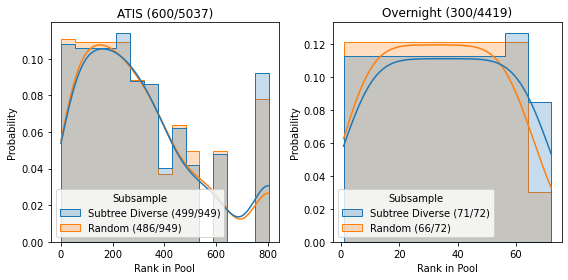

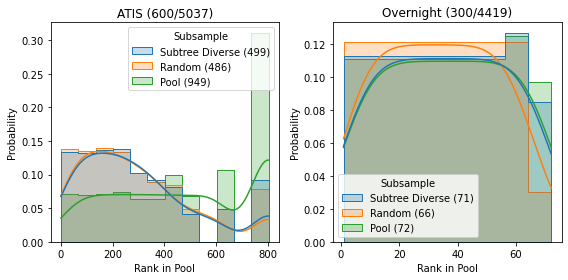

In [23]:
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_freq_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_unigram2ex_d, comp_name='subtree', plot_fn=plot_fn)
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_rank_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_unigram2ex_d, comp_name='subtree', plot_fn=plot_fn)

### Bigrams

In [24]:
all_bigram2ex_d = {ds_name: {name: get_sent_ngrams(df, max_n=2, min_n=2)[0] 
                             for name, df in dfs.items()}
                   for ds_name, dfs in all_dfs.items()}
bigram_counts_df = pd.DataFrame.from_records([
    dict(ds=ds_name, sample=name, metric_name='bigram_cnt', metric_val=len(bigram2ex))
    for ds_name, bigram2ex_d in all_bigram2ex_d.items()
    for name, bigram2ex in bigram2ex_d.items()
])
display(bigram_counts_df.pivot(index='ds', columns='sample', values='metric_val'))

sample,diverse,full,random
ds,,,
atis,2345,6324,1860
overnight,223,243,196


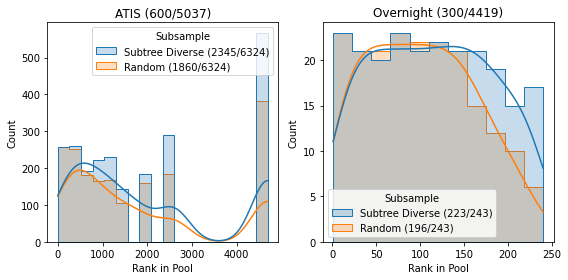

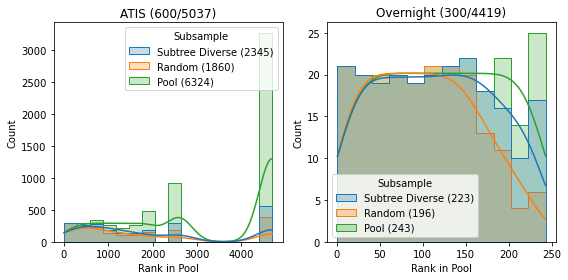

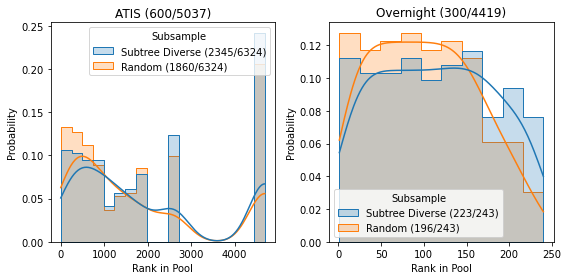

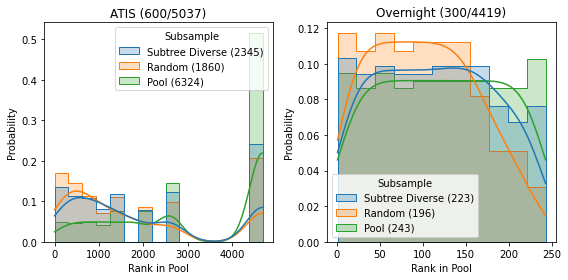

In [25]:
# rank
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_rank_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_bigram2ex_d, comp_name='subtree', plot_fn=plot_fn)

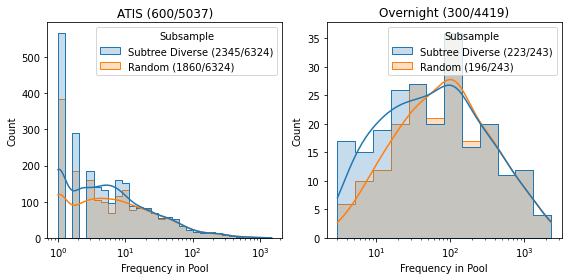

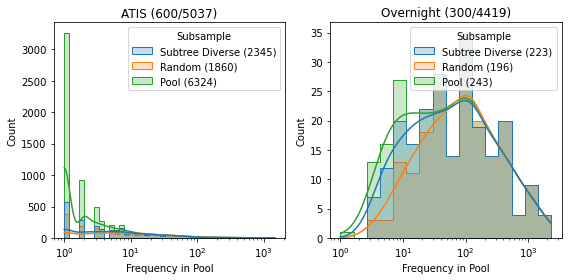

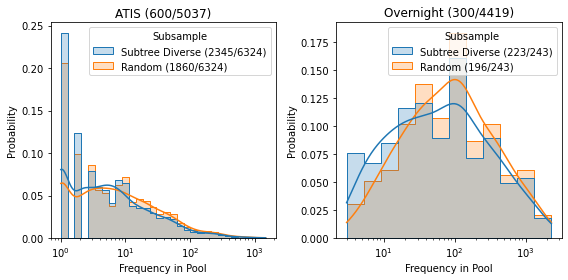

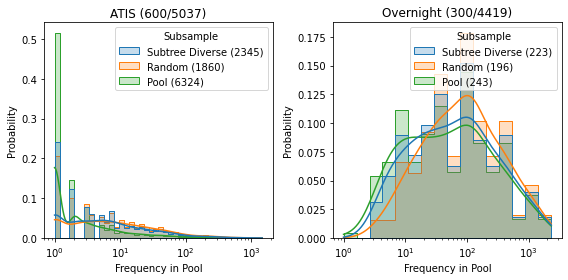

In [26]:
# frequency
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_freq_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_bigram2ex_d, comp_name='subtree', plot_fn=plot_fn)

### Trigrams

In [27]:
all_trigram2ex_d = {ds_name: {name: get_sent_ngrams(df, max_n=3, min_n=3)[0] 
                             for name, df in dfs.items()}
                   for ds_name, dfs in all_dfs.items()}
trigram_counts_df = pd.DataFrame.from_records([
    dict(ds=ds_name, sample=name, metric_name='trigram_cnt', metric_val=len(trigram2ex))
    for ds_name, trigram2ex_d in all_trigram2ex_d.items()
    for name, trigram2ex in trigram2ex_d.items()
])
display(trigram_counts_df.pivot(index='ds', columns='sample', values='metric_val'))

sample,diverse,full,random
ds,,,
atis,4012,13794,3042
overnight,424,472,340


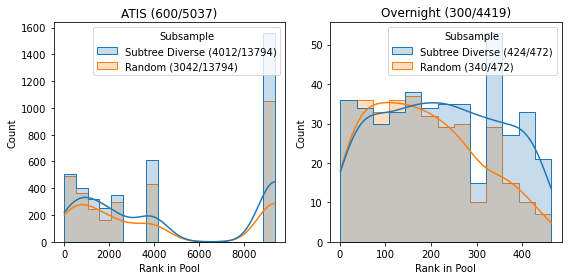

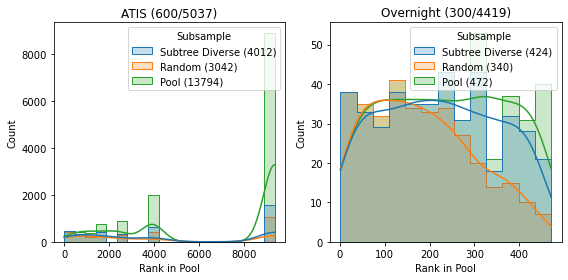

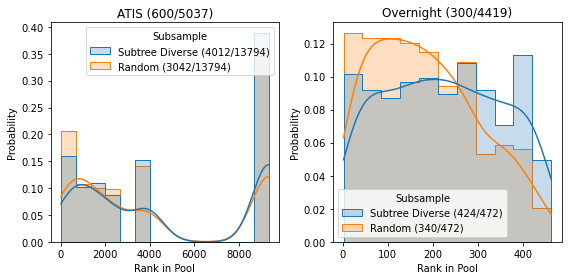

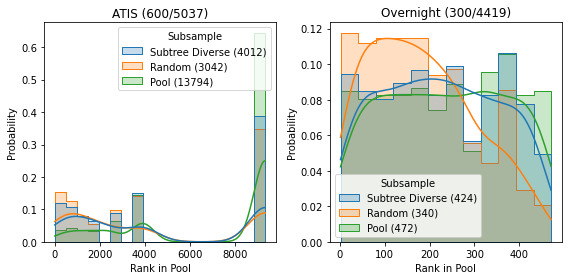

In [28]:
# rank
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_rank_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_trigram2ex_d, comp_name='subtree', plot_fn=plot_fn)

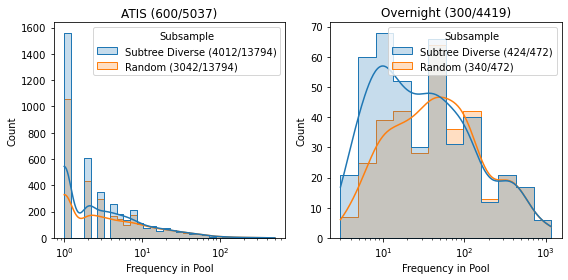

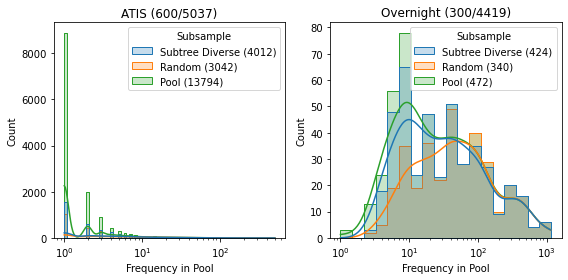

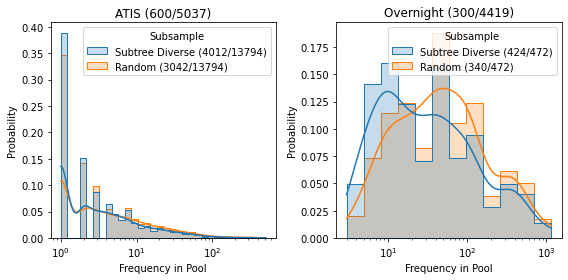

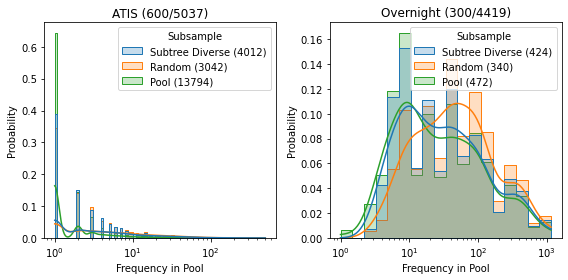

In [29]:
# frequency
for normalize in [False, True]:
    for plot_pool in [False, True]:
        plot_fn = partial(plot_pool_freq_hist, normalize=normalize, plot_pool=plot_pool)
        plot_pool_freq_hist_all(all_trigram2ex_d, comp_name='subtree', plot_fn=plot_fn)

### Final

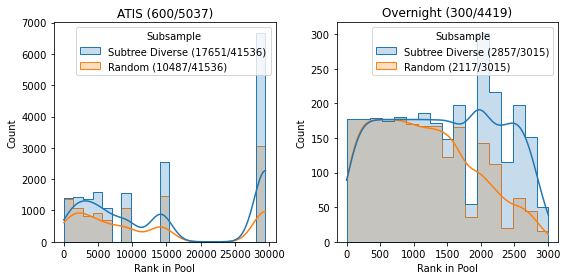

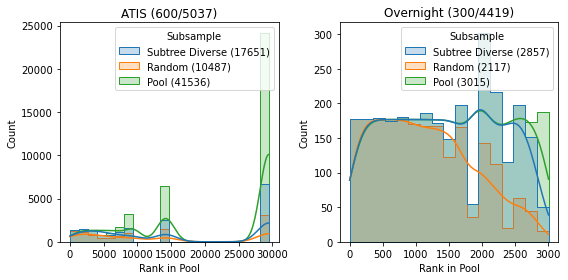

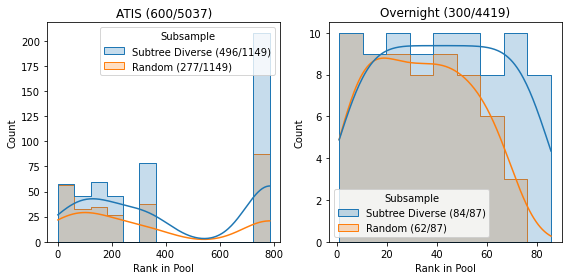

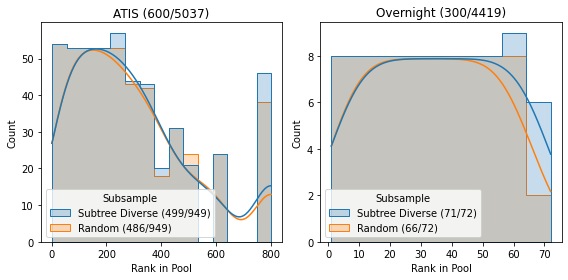

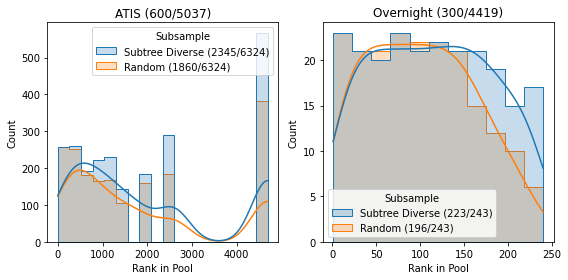

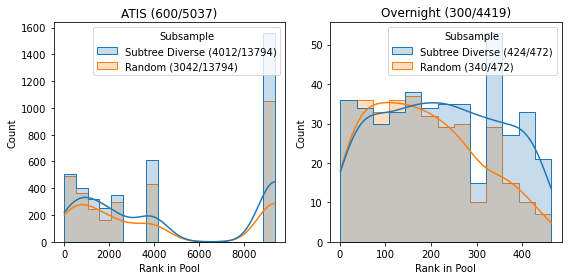

In [30]:
plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_subtree2ex_d, comp_name='subtree', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_unigram2ex_d, comp_name='unigram', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_bigram2ex_d, comp_name='bigram', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=False)
plot_pool_freq_hist_all(all_trigram2ex_d, comp_name='trigram', plot_fn=plot_fn, plot_name=plot_name)

In [ ]:
plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_template2ex_d, comp_name='template', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_unigram2ex_d, comp_name='unigram', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_bigram2ex_d, comp_name='bigram', plot_fn=plot_fn, plot_name=plot_name)

plot_fn = partial(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_name = get_plot_name(plot_pool_rank_hist, normalize=False, plot_pool=True)
plot_pool_freq_hist_all(all_trigram2ex_d, comp_name='trigram', plot_fn=plot_fn, plot_name=plot_name)

### Misc

In [31]:
if False:
    from bert_score import BERTScorer
    scorer = BERTScorer(lang="en", rescale_with_baseline=True, batch_size=128)
    mean_bert_score_l = []
    for ds_name, dfs in all_dfs.items():
        for name, df in dfs.items():
            sources = list(df.source)
            total_P, total_R, total_F1 = 0, 0, 0
            total_metric = {'P': 0, 'R': 0, 'F1': 0}
            total_cnt = 0
            all_P, all_R, all_F1 = scorer.score(*zip(*itertools.combinations(sources, r=2)))
            for metric_name in ['P', 'R', 'F1']:
                mean_bert_score_l.append(dict(ds=ds_name_map[ds_name], sample=name, 
                                            metric_name=metric_name, metric_val=eval(f'all_{metric_name}').sum().item()/eval(f'all_{metric_name}').shape[0]))
            # for pair in track(itertools.combinations(sources, r=2), 
            #                    total=len(sources) * (len(sources)-1) / 2,
            #                    disable=True):
            #     print(pair)
            #     P, R, F1 = scorer.score(pair[0], pair[1])
            #     total_P += P
            #     total_R += R
            #     total_F1 += F1
            #     total_cnt += 1
            # for metric_name in ['P', 'R', 'F1']:
            #     mean_bert_score_l.append(dict(ds=ds_name_map[ds_name], sample=name, 
            #                                   metric_name=metric_name, metric_val=eval(f'total_{metric_name}')/total_cnt))
    mean_bert_score_df = pd.DataFrame.from_records(mean_bert_score_l)
    display(mean_bert_score_df.pivot(index='ds', columns=['metric_name', 'sample'], values='metric_val').sort_index(axis=1, level=[0, 1]))

In [32]:
if False:
    import itertools
    import nltk.translate.bleu_score as bleu
    mean_bleu_score_l = []
    for ds_name, dfs in all_dfs.items():
        for name, df in dfs.items():
            if name == 'full': continue
            sources = list(df.source)
            total_P, total_R, total_F1 = 0, 0, 0
            total_metric = {'P': 0, 'R': 0, 'F1': 0}
            total_bleu, total_cnt = 0, 0
            for pair in track(itertools.combinations(sources, r=2), 
                            total=len(sources) * (len(sources)-1) / 2,
                            disable=False):
                score = bleu.sentence_bleu([pair[0]], pair[1])
                total_bleu += score
                total_cnt += 1
            mean_bleu_score_l.append(dict(ds=ds_name_map[ds_name], sample=name, 
                                        metric_name='bleu_score', metric_val=total_bleu/total_cnt))
    mean_bleu_score_df = pd.DataFrame.from_records(mean_bleu_score_l)
    display(mean_bleu_score_df.pivot(index='ds', columns=['metric_name', 'sample'], values='metric_val').sort_index(axis=1, level=[0, 1]))